In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('averaged_pings.txt', sep=",", names=["Service", "Timestamp", "ping_time"])
df['ping_time'] = df['ping_time'].str.extract('(\d+)').astype(int)


scaler = MinMaxScaler(feature_range=(0, 1))
df['ping_time_normalized'] = scaler.fit_transform(df[['ping_time']])


def create_sequences(input_data, window_size):
    sequences = []
    output = []
    for i in range(len(input_data) - window_size):
        sequences.append(input_data[i:(i + window_size)])
        output.append(input_data[i + window_size])
    return np.array(sequences), np.array(output)


input_data = df['ping_time_normalized'].values
print(len(input_data))
window_size =   10

X, y = create_sequences(input_data, window_size)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


31680
Shape of X: (31670, 10)
Shape of y: (31670,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


input_shape = (10, 1)
output_size = 2


model = Sequential([
    LSTM(50, activation='tanh', input_shape=input_shape, return_sequences=False),
    Dense(output_size)
])

def gaussian_likelihood(y_true, y_pred):
    mean, log_variance = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    log_variance = tf.clip_by_value(log_variance, clip_value_min=tf.math.log(1e-8), clip_value_max=tf.math.log(1e+8))
    variance = tf.exp(log_variance)

    epsilon = 1e-8
    gaussian_nll = 0.5 * (tf.math.log(variance + epsilon) + tf.square(y_true - mean) / (variance + epsilon))


    return tf.reduce_mean(gaussian_nll)

model.compile(optimizer='adam', loss=gaussian_likelihood)


print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10502 (41.02 KB)
Trainable params: 10502 (41.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


y_reshaped = y.reshape(-1, 1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_reshaped, test_size=0.2, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("Training data checks:")
print("X_train - NaNs:", np.isnan(X_train).sum(), "Infs:", np.isinf(X_train).sum())
print("y_train - NaNs:", np.isnan(y_train).sum(), "Infs:", np.isinf(y_train).sum())
print("Validation data checks:")
print("X_val - NaNs:", np.isnan(X_test).sum(), "Infs:", np.isinf(X_test).sum())
print("y_val - NaNs:", np.isnan(y_test).sum(), "Infs:", np.isinf(y_test).sum())


epochs_size = 50
batch_size = 32


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=epochs_size,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

model.save('my_new_lstm_model.h5')


Training data checks:
X_train - NaNs: 0 Infs: 0
y_train - NaNs: 0 Infs: 0
Validation data checks:
X_val - NaNs: 0 Infs: 0
y_val - NaNs: 0 Infs: 0
Epoch 1/50
792/792 [==============================] - 9s 8ms/step - loss: -2.8714 - val_loss: -3.0727
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: -3.0279 - val_loss: -2.6946
Epoch 3/50
792/792 [==============================] - 6s 7ms/step - loss: -3.1044 - val_loss: -3.0588
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: -3.1316 - val_loss: -3.1311
Epoch 5/50
792/792 [==============================] - 5s 7ms/step - loss: -3.1377 - val_loss: -3.0954
Epoch 6/50
792/792 [==============================] - 6s 7ms/step - loss: -3.1851 - val_loss: -3.0650
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: -3.1833 - val_loss: -3.1306
Epoch 8/50
792/792 [==============================] - 6s 7ms/step - loss: -3.2161 - val_loss: -3.1754
Epoch 9/50
792/792 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error

def validate_model(model, X_test, y_test):

    predictions = model.predict(X_test)


    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


    mse = mean_squared_error(y_test, predictions[:, 0])

    nll_loss = gaussian_likelihood(y_test_tensor, predictions)

    log_likelihood = -nll_loss.numpy()

    return mse, log_likelihood




mse, mean_log_likelihood = validate_model(model, X_test, y_test)
print(f"Mean Squared Error: {mse}")
print(f"Mean Log Likelihood: {mean_log_likelihood}")



predictions = model.predict(X_test)


predicted_means, predicted_variances = predictions[:, 0], predictions[:, 1]
predicted_stddevs = np.sqrt(np.exp(predicted_variances))


actual_values = y_test.flatten()


198/198 [==============================] - 1s 4ms/step
Mean Squared Error: 0.0007569748485839032
Mean Log Likelihood: 3.3411993980407715
198/198 [==============================] - 1s 5ms/step


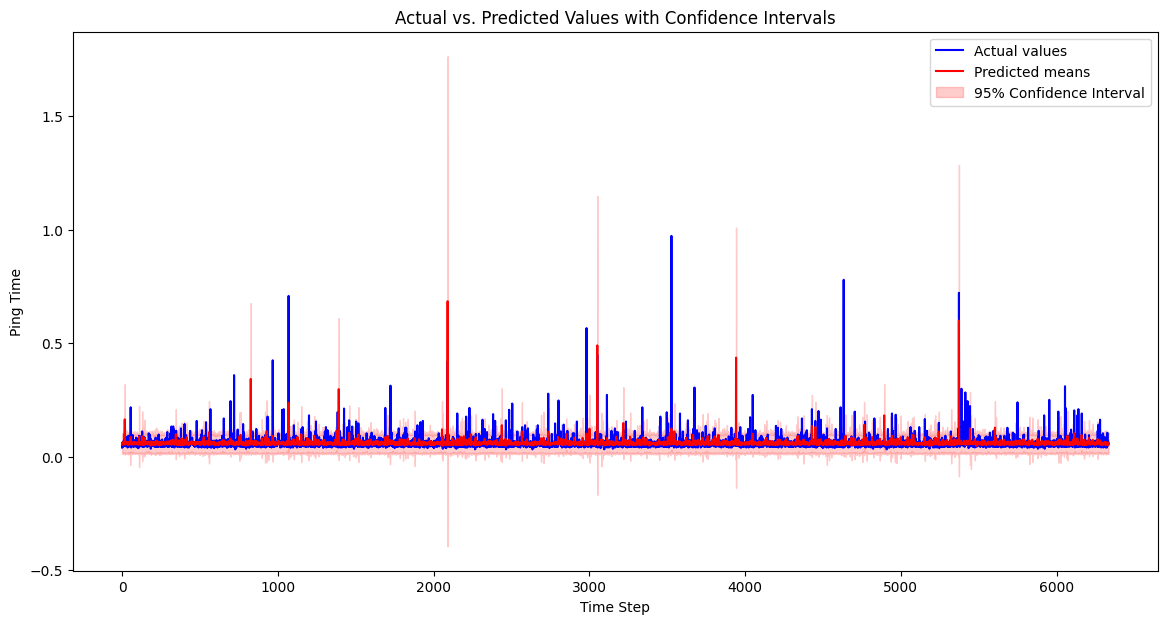

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual values', color='blue')
plt.plot(predicted_means, label='Predicted means', color='red')


lower_bounds = predicted_means - 1.96 * predicted_stddevs
upper_bounds = predicted_means + 1.96 * predicted_stddevs

plt.fill_between(range(len(predicted_means)), lower_bounds, upper_bounds, color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Actual vs. Predicted Values with Confidence Intervals')
plt.xlabel('Time Step')
plt.ylabel('Ping Time')
plt.legend()
plt.show()


1/1 [==============================] - 0s 54ms/step


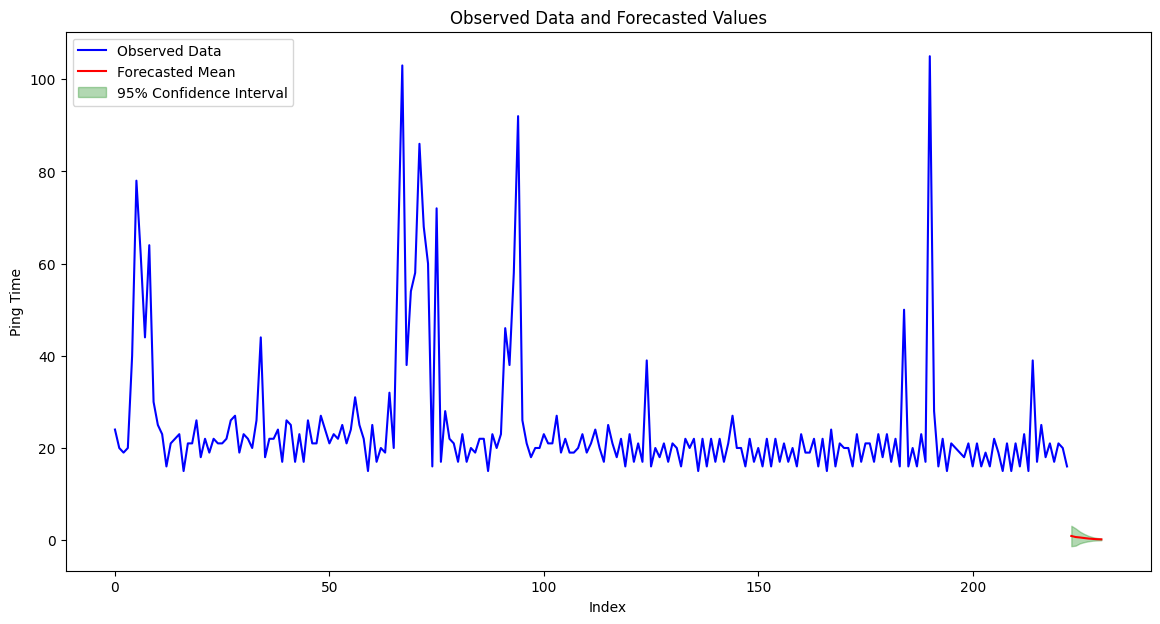

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.preprocessing import MinMaxScaler



def plot_forecast(data_frame, model, window_size=10, steps_ahead=8, max_log_var=10.0):

    last_window = data_frame['ping_time'].values[-window_size:]
    input_sequence = np.array(last_window).reshape((1, window_size, 1))


    forecasted_means = []
    forecasted_stddevs = []
    for _ in range(steps_ahead):

        prediction = model.predict(input_sequence)


        log_variance = np.clip(prediction[0, 1], None, max_log_var)


        next_mean = prediction[0, 0]
        next_stddev = np.sqrt(np.exp(log_variance))


        forecasted_means.append(next_mean)
        forecasted_stddevs.append(next_stddev)


        next_mean_reshaped = np.array([[next_mean]])
        input_sequence = np.append(input_sequence[:, 1:, :], next_mean_reshaped.reshape(1, 1, 1), axis=1)

    forecasted_means = np.array(forecasted_means)
    forecasted_stddevs = np.array(forecasted_stddevs)


    forecast_indices = np.arange(len(data_frame), len(data_frame) + steps_ahead)


    plt.figure(figsize=(14, 7))
    plt.plot(data_frame.index, data_frame['ping_time'], label='Observed Data', color='blue')


    plt.plot(forecast_indices, forecasted_means, label='Forecasted Mean', color='red')


    lower_bounds = forecasted_means - 1.96 * forecasted_stddevs
    upper_bounds = forecasted_means + 1.96 * forecasted_stddevs
    plt.fill_between(forecast_indices, lower_bounds, upper_bounds, color='green', alpha=0.3, label='95% Confidence Interval')

    plt.title('Observed Data and Forecasted Values')
    plt.xlabel('Index')
    plt.ylabel('Ping Time')
    plt.legend()
    plt.show()






scaler = MinMaxScaler(feature_range=(0, 1))
data_validate = pd.read_csv('samplepings.txt', sep=",", names=["Service", "Timestamp", "ping_time"])
data_validate['ping_time'] = data_validate['ping_time'].str.extract('(\d+)').astype(int)
data_validate['ping_time_normalized'] = scaler.fit_transform(data_validate[['ping_time']])
validation_data = data_validate['ping_time_normalized'].values

custom_objects = {'gaussian_likelihood': gaussian_likelihood}

model = load_model('my_new_lstm_model.h5', custom_objects=custom_objects)  
plot_forecast(data_validate, model)
